## Nolan Karsok Machine Learning Course Project

## Table of Contents:
* <font size="4"><a href="#1">Import Necessary Packages and Libraries</a></font></font>
* <font size="4"><a href="#2">Data Preprocessing and Cleaning</a></font>
* <font size="4"><a href="#3">Exploratory Data Analysis</a></font>
* <font size="4"><a href="4#">Model Building</a></font>
    * <font size="4"><a href="#4.1">Logistic Regression</a></font>
    * <font size="4"><a href="#4.2">K-Nearest Neighbor</a></font>
    * <font size="4"><a href="#4.3">Random Forest</a></font>
    * <font size="4"><a href="#4.4">Gradient Boosting</a></font>
    * <font size="4"><a href="#4.5">Support Vector Machine</a></font>
    * <font size="4"><a href="#4.6">Decision Tree</a></font>
* <font size="4"><a href="5#">Cross Validation</a></font>
* <font size="4"><a href="6#">Scoring Metric Comparison</a></font>
* <font size="4"><a href="7#">Model Selection</a></font>

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Import Necessary Packages and Libraries <a class="anchor" id="1"></a>

In [2]:
#Data Preprocessing Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
import graphviz
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest,chi2

#Model Building Packages
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC

#Model Evaluation Packages
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

## Data Preprocessing and Cleaning <a class="anchor" id="2"></a>

In [3]:
# Load the dataset
df = pd.read_csv('C:/Users/nkars/OneDrive/Documents/Machine Learning/Course Project/survey lung cancer.csv')

In [4]:
for categorical_column in df:
    if categorical_column == 'AGE': # Skip the 'AGE' column as it is continuous numerical attribute
        continue
    df[categorical_column]=LabelEncoder().fit_transform(df[categorical_column])

In [5]:
X = df.drop('LUNG_CANCER', axis=1) # Features
y = df['LUNG_CANCER'] # Target variable

In [6]:
# assuming X is the feature matrix and y is the target vector
# instantiate SelectKBest with chi2 scoring function and k=10 (select top 10 features)
selector = SelectKBest(chi2, k=10)

# fit the selector to the data
selector.fit(X, y)

# transform the data to keep only the selected features
X_selected = selector.transform(X)

# get the names of the selected features
selected_feature_names = X.columns[selector.get_support()]

# print the selected features
print("Selected feature names:", selected_feature_names)

Selected feature names: Index(['AGE', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE', 'ALLERGY ',
       'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SWALLOWING DIFFICULTY',
       'CHEST PAIN'],
      dtype='object')


In [7]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (247, 10)
Test shape: (62, 10)


In [8]:
# resample minority class in both test and train
# We do this after the split so that duplicates don't pollute either set
X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)
X_test, y_test = RandomOverSampler().fit_resample(X_test, y_test)
print(f'Train_resampled shape : {X_train.shape}\nTest_resampled shape: {X_test.shape}')

Train_resampled shape : (420, 10)
Test_resampled shape: (120, 10)


## Exploratory Data Analysis <a class="anchor" id="3"></a>

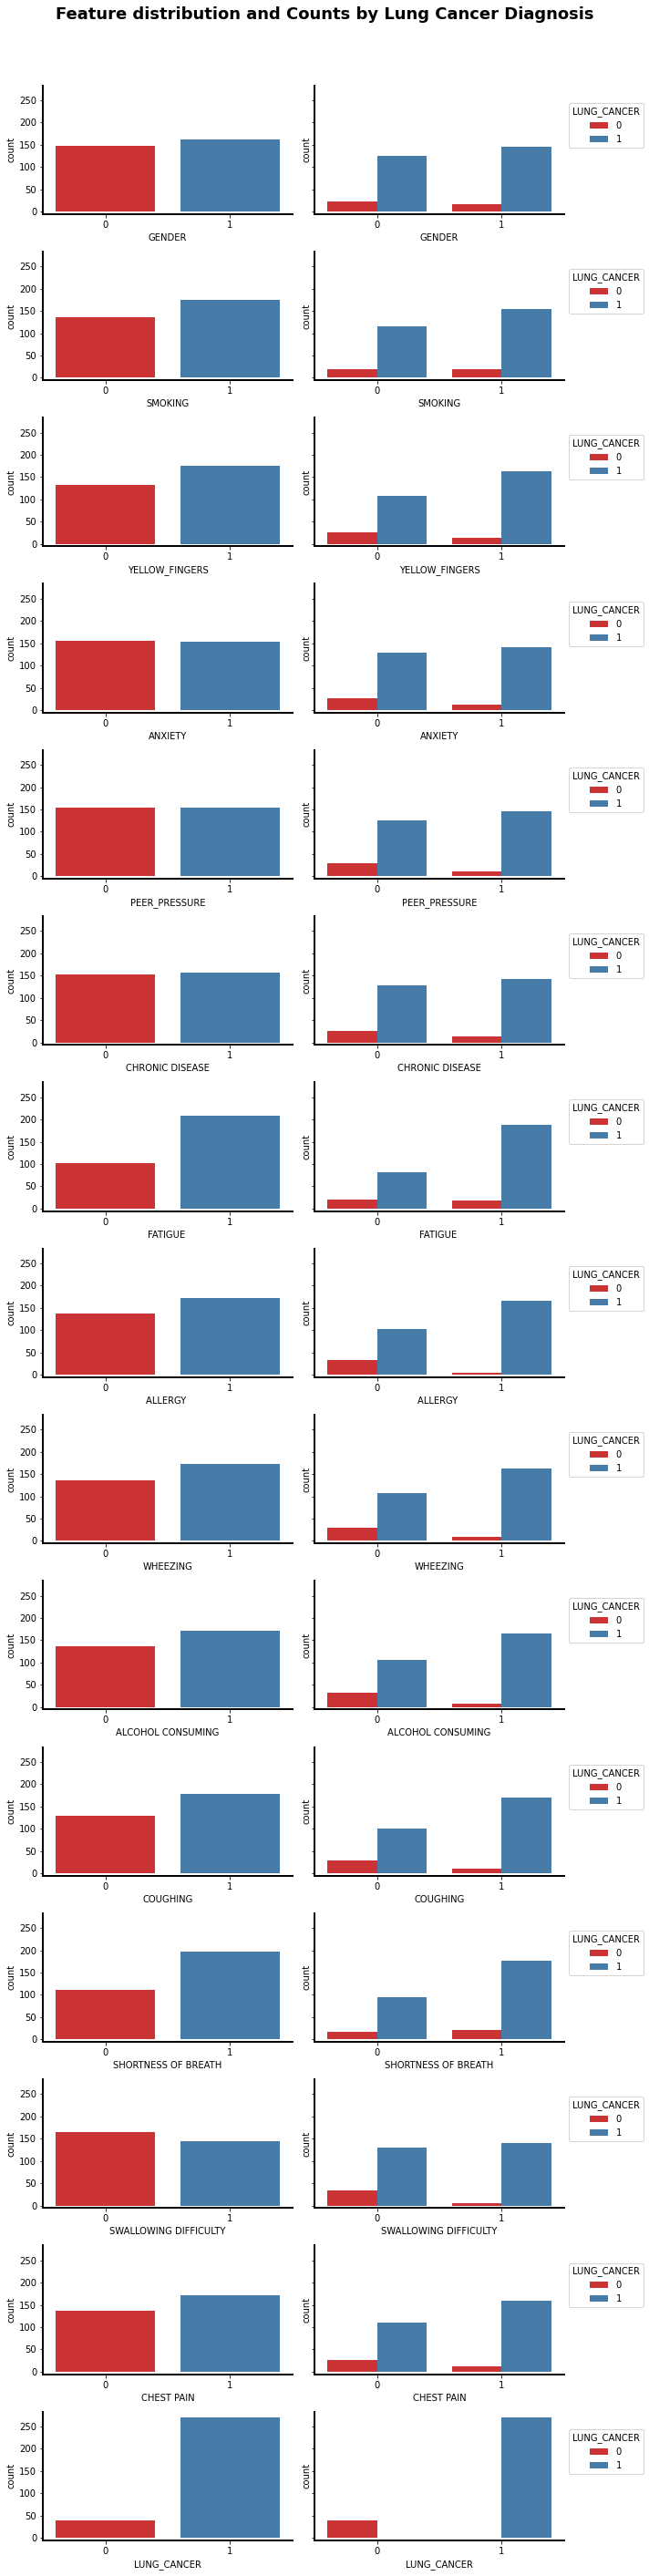

In [9]:
num_features = len(df.columns) - 1 # Exclude age

fig, axs = plt.subplots(num_features, 2, figsize=(10, 40), sharey=True)

# Loop over attributes that are not 'AGE'
cat_attributes = [col for col in df.columns if col != 'AGE']
for i, cat_attr in enumerate(cat_attributes):
        if cat_attr != 'AGE':
            sns.countplot(data=df, x=cat_attr, ax=axs[i, 0], palette='Set1')
            sns.countplot(data=df, x=cat_attr, hue='LUNG_CANCER', ax=axs[i, 1], palette='Set1')
            sns.move_legend(axs[i, 1], bbox_to_anchor=(1,0.9),loc='upper left')

for ax in axs.flatten():
        # Adjust the bottom of the plot to the x-axis with a tiny space
        y_bounds = ax.get_ybound()
        y_bottom = (y_bounds[0] + y_bounds[1]) / 50 * -1
        ax.set_ylim(y_bottom, ax.get_ybound()[1])
        # Remove or enhance plot spines (bounding box)
        for spine in ['top', 'right']:
            ax.spines[spine].set_linewidth(0)
        for spine in ['bottom', 'left']:
            ax.spines[spine].set_linewidth(2)
plt.suptitle("Feature distribution and Counts by Lung Cancer Diagnosis", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

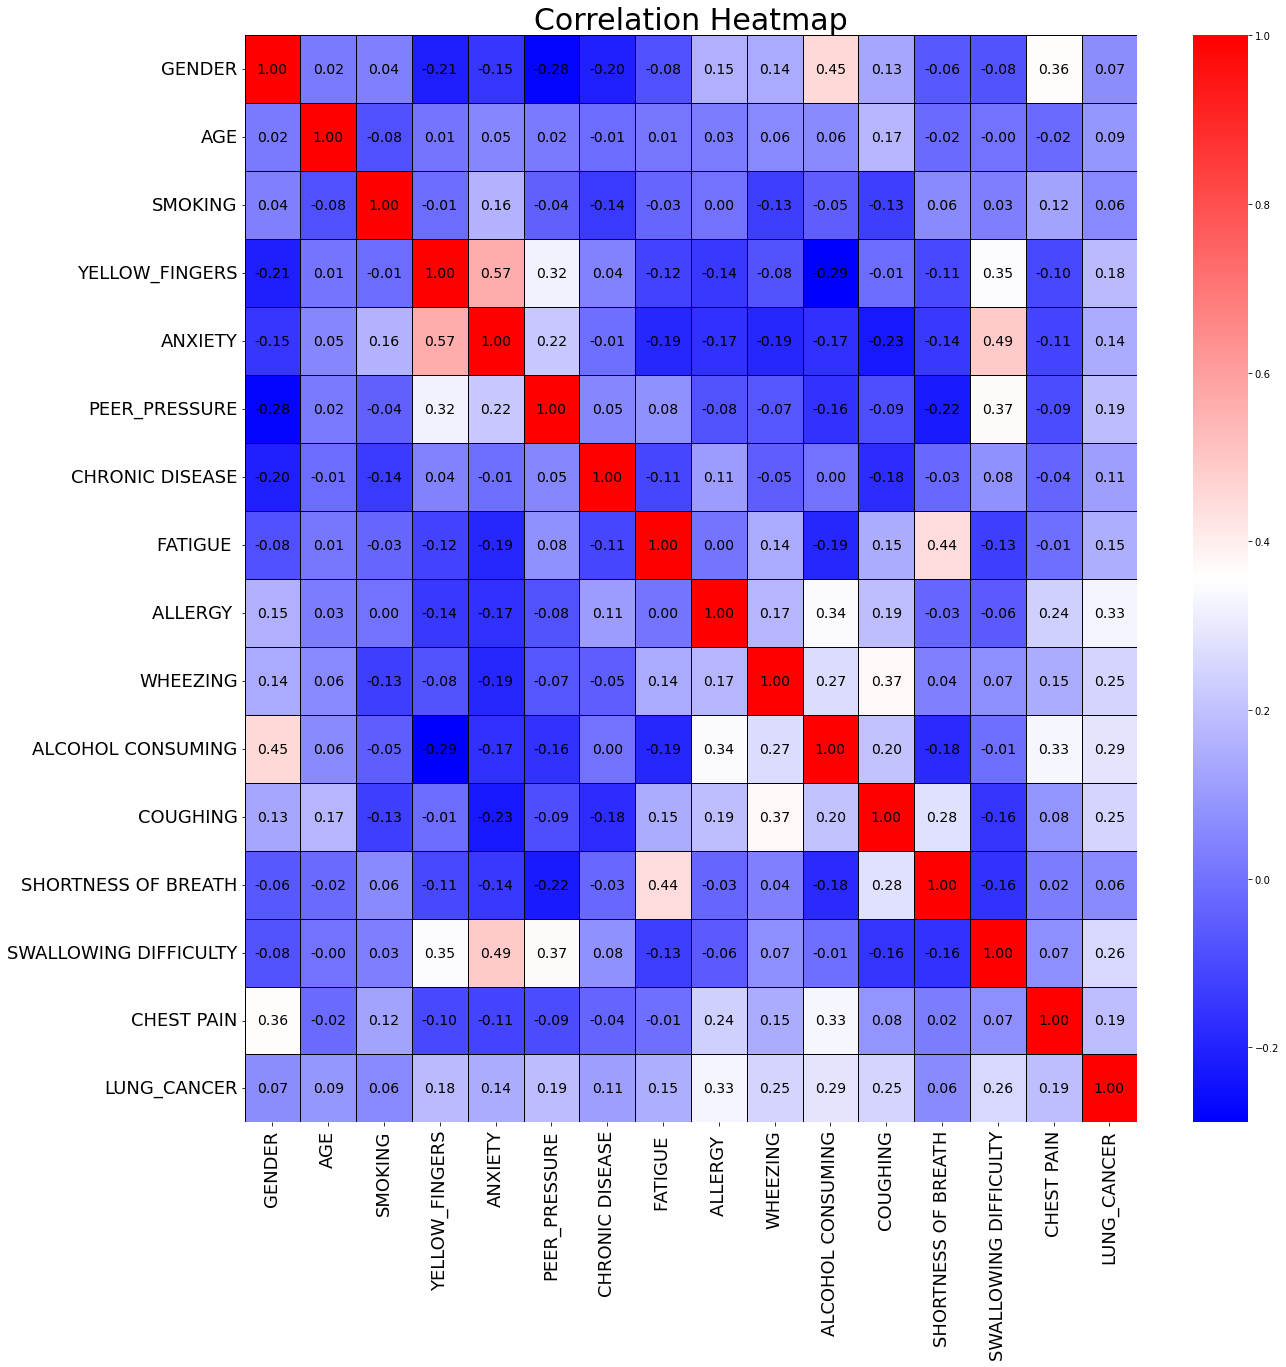

In [10]:
# Create a correlation matrix using Pandas corr() method
corr_matrix = df.corr()

# Create a heatmap using Seaborn heatmap() method
fig, axs = plt.subplots(figsize=(20,20))

sns.heatmap(corr_matrix, 
            annot=True, 
            linewidth=0.5, 
            linecolor='k', 
            fmt='0.2f', 
            annot_kws={"size": 14, "color": "black"}, 
            cmap="bwr")

# Set plot title and labels
plt.title("Correlation Heatmap", fontsize=30)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Show plot
plt.show()

## Model Building <a class="anchor" id="4"></a>

## Logistic Regression <a class="anchor" id="4.1"></a>

In logistic regression, the goal is to find the coefficients of a linear equation that best predicts the probability of a binary outcome. The logistic function is used to convert the linear equation into a probability, which can then be thresholded to make a classification decision. The coefficients are typically estimated using maximum likelihood estimation or a similar optimization algorithm.

In [11]:
# Create a Logistic Regression object
logreg = LogisticRegression()

# Train the model using the training sets
logreg.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = logreg.predict(X_test)

# Print the classification report of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        60
           1       0.69      0.92      0.79        60

    accuracy                           0.75       120
   macro avg       0.78      0.75      0.74       120
weighted avg       0.78      0.75      0.74       120



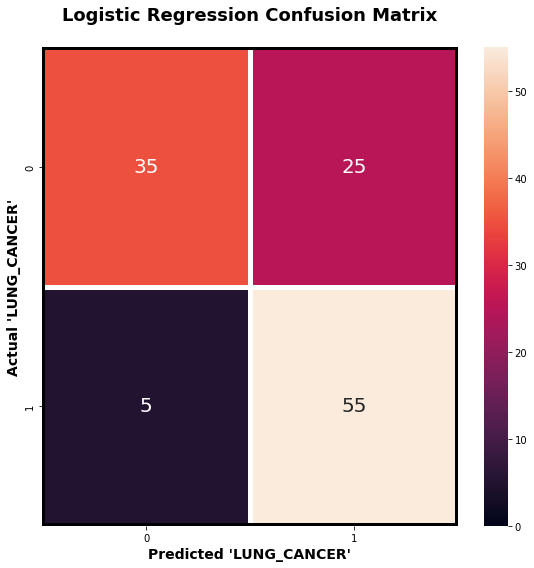

In [12]:
fig, axs = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            linewidth=5, 
            vmin=0, 
            cmap='rocket', 
            ax=axs, 
            annot_kws={"fontsize":20})
axs.set_title('Logistic Regression Confusion Matrix\n', fontsize=18, fontweight='bold')
axs.set_xlabel("Predicted 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.set_ylabel("Actual 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.axhline(y=0, color='k',linewidth=5)
axs.axhline(y=confusion_matrix(y_test, y_pred).shape[1], color='k',linewidth=7)
axs.axvline(x=0, color='k',linewidth=5)
axs.axvline(x=confusion_matrix(y_test, y_pred).shape[0], color='k',linewidth=7)
plt.tight_layout()
plt.show()

In [13]:
# Get the recall score for the positive class (assuming class 1 is the positive class)
logreg_accuracy = accuracy_score(y_test, y_pred)
logreg_recall = recall_score(y_test, y_pred, labels=1)
logreg_avg_recall = recall_score(y_test, y_pred, average='weighted')

## K-Nearest Neighbor <a class="anchor" id="4.2"></a>

In KNN, the output value of a new data point is determined by the labels of its K-nearest neighbors in the training set. KNN uses a distance metric (e.g. Euclidean distance) to determine which points are closest. The value of K is a hyperparameter that must be tuned. KNN can be used for both classification and regression tasks.

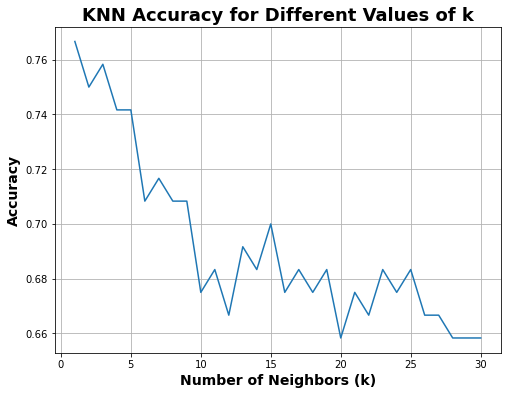

The highest accuracy score is 0.7666666666666667 for k = 1


In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the range of k values to test
k_values = range(1, 31)

# Train a KNN model for each value of k and record the accuracy scores
accuracy_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Get the value of k that corresponds to the highest accuracy score
best_k = k_values[accuracy_scores.index(max(accuracy_scores))]

# Plot the accuracy scores against the corresponding k values
fig, axs = plt.subplots(figsize=(8, 6))

plt.plot(k_values, accuracy_scores)
plt.title('KNN Accuracy for Different Values of k', fontsize=18, fontweight='bold')
plt.xlabel('Number of Neighbors (k)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, which='both')
plt.show()

print(f"The highest accuracy score is {max(accuracy_scores)} for k = {best_k}")

In [15]:
# Create a KNN object
k = best_k
knn = KNeighborsClassifier(n_neighbors=k)

# Train the model using the training sets
knn.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)

# Generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.58      0.71        60
           1       0.70      0.95      0.80        60

    accuracy                           0.77       120
   macro avg       0.81      0.77      0.76       120
weighted avg       0.81      0.77      0.76       120



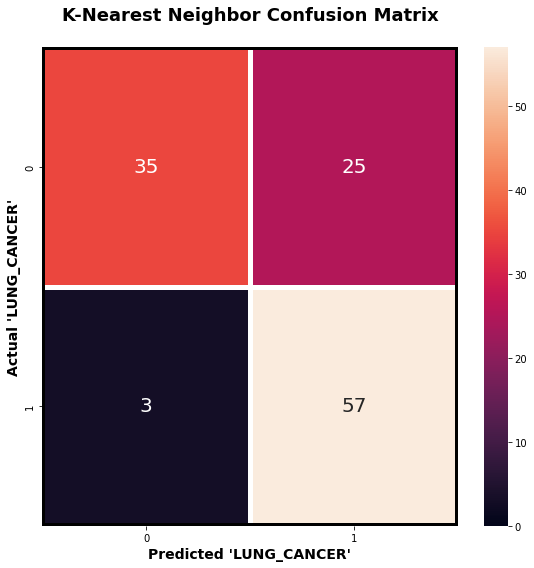

In [16]:
fig, axs = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            linewidth=5, 
            vmin=0, 
            cmap='rocket', 
            ax=axs, 
            annot_kws={"fontsize":20})
axs.set_title('K-Nearest Neighbor Confusion Matrix\n', fontsize=18, fontweight='bold')
axs.set_xlabel("Predicted 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.set_ylabel("Actual 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.axhline(y=0, color='k',linewidth=5)
axs.axhline(y=confusion_matrix(y_test, y_pred).shape[1], color='k',linewidth=7)
axs.axvline(x=0, color='k',linewidth=5)
axs.axvline(x=confusion_matrix(y_test, y_pred).shape[0], color='k',linewidth=7)
plt.tight_layout()
plt.show()

In [17]:
# Get the recall score for the positive class (assuming class 1 is the positive class)
knn_accuracy = accuracy_score(y_test, y_pred)
knn_recall = recall_score(y_test, y_pred, labels=1)
knn_avg_recall = recall_score(y_test, y_pred, average='weighted')

## Random Forest <a class="anchor" id="4.3"></a>

A random forest consists of many decision trees, where each tree is constructed using a random subset of the features and training data. The output of the random forest is the average (for regression) or mode (for classification) of the predictions of the individual trees. Random forests can be used for both classification and regression tasks. The algorithm can handle missing data and is robust to overfitting.

In [18]:
# Create a Random Forest object
n_estimators = 100
rf = RandomForestClassifier(n_estimators=n_estimators)

# Train the model using the training sets
rf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)

# Generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.58      0.72        60
           1       0.70      0.97      0.81        60

    accuracy                           0.78       120
   macro avg       0.82      0.78      0.77       120
weighted avg       0.82      0.78      0.77       120



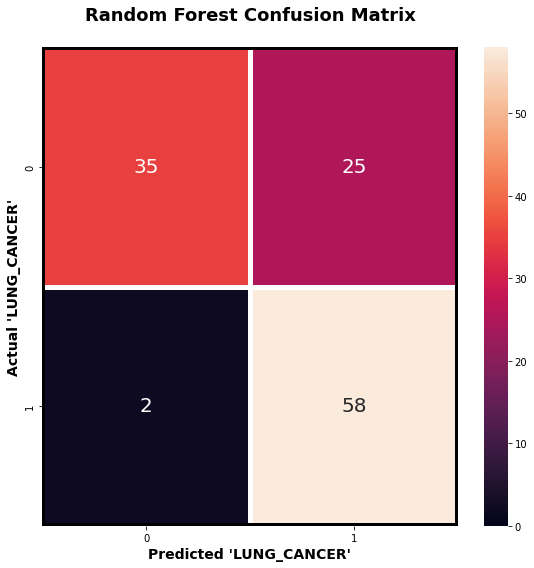

In [19]:
fig, axs = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            linewidth=5, 
            vmin=0, 
            cmap='rocket', 
            ax=axs, 
            annot_kws={"fontsize":20})
axs.set_title('Random Forest Confusion Matrix\n', fontsize=18, fontweight='bold')
axs.set_xlabel("Predicted 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.set_ylabel("Actual 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.axhline(y=0, color='k',linewidth=5)
axs.axhline(y=confusion_matrix(y_test, y_pred).shape[1], color='k',linewidth=7)
axs.axvline(x=0, color='k',linewidth=5)
axs.axvline(x=confusion_matrix(y_test, y_pred).shape[0], color='k',linewidth=7)
plt.tight_layout()
plt.show()

In [20]:
# Get the recall score for the positive class (assuming class 1 is the positive class)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred, labels=1)
rf_avg_recall = recall_score(y_test, y_pred, average='weighted')

## Gradient Boosting <a class="anchor" id="4.4"></a>

In gradient boosting, decision trees are built sequentially, with each tree attempting to correct the errors of the previous one. The output of the final model is a weighted sum of these trees. Gradient boosting typically uses a loss function (e.g. mean squared error for regression or binary cross-entropy for classification) to measure the error of the current model, and then updates the weights of the training data to focus on the examples that were incorrectly predicted. This process is repeated until convergence.

In [21]:
# Create a Gradient Boosting object
n_estimators = 100
gb = GradientBoostingClassifier(n_estimators=n_estimators)

# Train the model using the training sets
gb.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred)

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.58      0.71        60
           1       0.70      0.95      0.80        60

    accuracy                           0.77       120
   macro avg       0.81      0.77      0.76       120
weighted avg       0.81      0.77      0.76       120



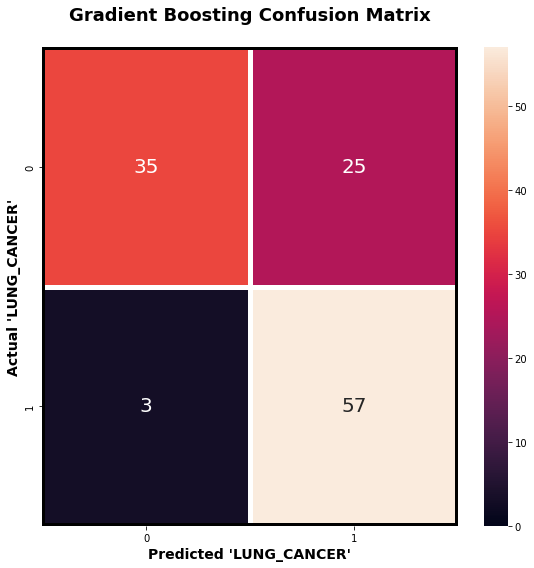

In [22]:
fig, axs = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            linewidth=5, 
            vmin=0, 
            cmap='rocket', 
            ax=axs, 
            annot_kws={"fontsize":20})
axs.set_title('Gradient Boosting Confusion Matrix\n', fontsize=18, fontweight='bold')
axs.set_xlabel("Predicted 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.set_ylabel("Actual 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.axhline(y=0, color='k',linewidth=5)
axs.axhline(y=confusion_matrix(y_test, y_pred).shape[1], color='k',linewidth=7)
axs.axvline(x=0, color='k',linewidth=5)
axs.axvline(x=confusion_matrix(y_test, y_pred).shape[0], color='k',linewidth=7)
plt.tight_layout()
plt.show()

In [23]:
# Get the recall score for the positive class (assuming class 1 is the positive class)
gb_accuracy = accuracy_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred, labels=1)
gb_avg_recall = recall_score(y_test, y_pred, average='weighted')

## Support Vector Machine <a class="anchor" id="4.5"></a>

In SVM, the goal is to find a hyperplane that maximally separates two classes in the training data. The hyperplane is defined by a set of coefficients (the "support vectors") and a bias term. SVM can be used for both linear and nonlinear classification tasks by using a kernel function to map the data into a higher-dimensional feature space. The coefficients and bias term are typically found by solving a constrained optimization problem.

In [24]:
# Create a Support Vector Machine object
svm = SVC()

# Train the model using the training sets
svm.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)

# Generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.58      0.60        60
           1       0.60      0.63      0.62        60

    accuracy                           0.61       120
   macro avg       0.61      0.61      0.61       120
weighted avg       0.61      0.61      0.61       120



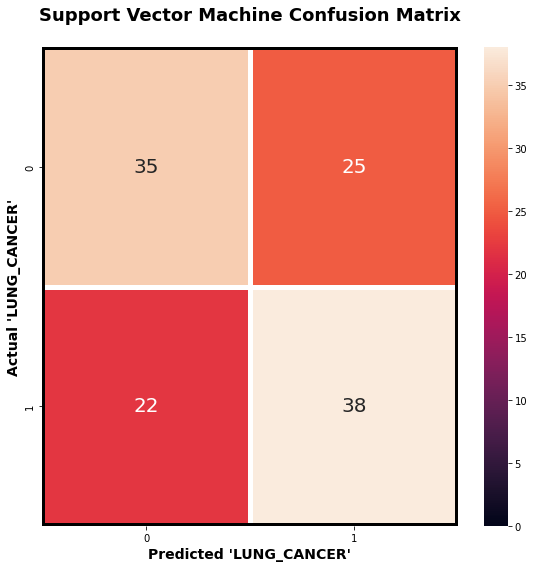

In [25]:
fig, axs = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            linewidth=5, 
            vmin=0, 
            cmap='rocket', 
            ax=axs, 
            annot_kws={"fontsize":20})
axs.set_title('Support Vector Machine Confusion Matrix\n', fontsize=18, fontweight='bold')
axs.set_xlabel("Predicted 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.set_ylabel("Actual 'LUNG_CANCER'", fontsize=14, fontweight='bold')
axs.axhline(y=0, color='k',linewidth=5)
axs.axhline(y=confusion_matrix(y_test, y_pred).shape[1], color='k',linewidth=7)
axs.axvline(x=0, color='k',linewidth=5)
axs.axvline(x=confusion_matrix(y_test, y_pred).shape[0], color='k',linewidth=7)
plt.tight_layout()
plt.show()

In [26]:
# Get the recall score for the positive class (assuming class 1 is the positive class)
svm_accuracy = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred, labels=1)
svm_avg_recall = recall_score(y_test, y_pred, average='weighted')

## Decision Tree <a class="anchor" id="4.6"></a>

In a decision tree, the data is recursively split into smaller subsets based on the values of the features, with each split attempting to maximize the separation between the classes (or minimize the variance in the case of regression). The splitting process continues until a stopping criterion is met (e.g. a maximum depth is reached, or all samples in a subset belong to the same class). The resulting tree can be used to make predictions for new data points by traversing the tree from the root to a leaf node, where the leaf node provides the predicted value or label.

In [27]:
# Create a Decision Tree object
dt = DecisionTreeClassifier()

# Train the model using the training sets
dt.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)

# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.58      0.71        60
           1       0.70      0.95      0.80        60

    accuracy                           0.77       120
   macro avg       0.81      0.77      0.76       120
weighted avg       0.81      0.77      0.76       120



In [28]:
# Get the recall score for the positive class (assuming class 1 is the positive class)
dt_accuracy = accuracy_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred, labels=1)
dt_avg_recall = recall_score(y_test, y_pred, average='weighted')

## Cross Validation <a class="anchor" id="5"></a>

Cross-validation is a technique used in machine learning to evaluate the performance of a model. It involves splitting the data into multiple "folds", where each fold is used as a test set while the remaining folds are used as training data. This process is repeated multiple times, with each fold used as a test set once, and the results are averaged to obtain a more robust estimate of the model's performance.

This code performs 10-fold cross-validation on a logistic regression model using the cross_val_score function from scikit-learn's model_selection module. It then prints the average cross-validation score of the logistic regression model obtained across all 10 folds. The cross-validation score represents the evaluation metric (e.g. accuracy, precision, recall, F1-score) of the model on each fold of the data during cross-validation. The cross_val_score function in scikit-learn returns an array of scores, one for each fold. The average of these scores is typically reported as the model's cross-validation score, which provides an estimate of the model's performance on unseen data.

In [29]:
# logistic regression
lr_classifier = LogisticRegression()
lr_scores = cross_val_score(lr_classifier, X, y, cv=10)
print("Logistic Regression Mean CV score:", lr_scores.mean())

# k-nearest neighbors
knn_classifier = KNeighborsClassifier()
knn_scores = cross_val_score(knn_classifier, X, y, cv=10)
print("K-Nearest Neighbors Mean CV score:", knn_scores.mean())

# random forest
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_scores = cross_val_score(rf_classifier, X, y, cv=10)
print("Random Forest Mean CV score:", rf_scores.mean())

# gradient boosting
gb_classifier = GradientBoostingClassifier()
gb_scores = cross_val_score(gb_classifier, X, y, cv=10)
print("Gradient Boosting Mean CV score:", gb_scores.mean())

# support vector machine
svm_classifier = SVC()
svm_scores = cross_val_score(svm_classifier, X, y, cv=10)
print("Support Vector Machine Mean CV score:", svm_scores.mean())

# decision tree
dt_classifier = DecisionTreeClassifier()
dt_scores = cross_val_score(dt_classifier, X, y, cv=10)
print("Decision Tree Mean CV score:", dt_scores.mean())

Logistic Regression Mean CV score: 0.9224731182795699
K-Nearest Neighbors Mean CV score: 0.8706451612903224
Random Forest Mean CV score: 0.9224731182795699
Gradient Boosting Mean CV score: 0.8933333333333333
Support Vector Machine Mean CV score: 0.8738709677419354
Decision Tree Mean CV score: 0.9


## Scoring Metric Comparison <a class="anchor" id="6"></a>

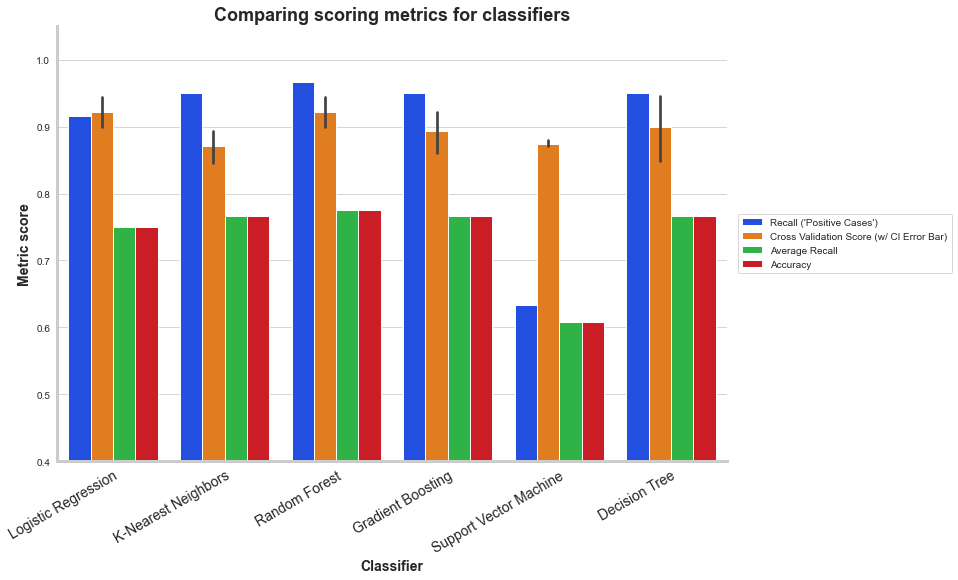

In [30]:
metric_scores = {
    'Classifier':['Logistic Regression', 
                  'K-Nearest Neighbors', 
                  'Random Forest', 
                  'Gradient Boosting', 
                  'Support Vector Machine', 
                  'Decision Tree'],
    "Recall ('Positive Cases')":[logreg_recall, knn_recall, rf_recall, gb_recall, svm_recall, dt_recall],
    'Cross Validation Score (w/ CI Error Bar)':[lr_scores, knn_scores, rf_scores, gb_scores, svm_scores, dt_scores],
    'Average Recall':[logreg_avg_recall, knn_avg_recall, rf_avg_recall, gb_avg_recall, svm_avg_recall, dt_avg_recall],
    'Accuracy':[logreg_accuracy, knn_accuracy, rf_accuracy, gb_accuracy, svm_accuracy, dt_accuracy]
}


metric_scores = pd.DataFrame(data=metric_scores)
metric_scores = pd.melt(metric_scores, id_vars='Classifier')
metric_scores.rename(columns={'variable':'Metric'}, inplace=True)

# explode the Cross Validation Score column
metric_scores = metric_scores.explode('value')

# convert the value column to numeric
metric_scores['value'] = metric_scores['value'].astype(float)


# set style and color palette
sns.set_style('whitegrid')
sns.set_palette('bright')

# set figure size
fig, axs = plt.subplots(figsize=(12, 8))

# create bar plot
sns.barplot(data=metric_scores, x='Classifier', y='value', hue='Metric', ax=axs)

# remove top and right spines
sns.despine(top=True, right=True)

# set x-axis labels
axs.set_xticklabels(axs.get_xticklabels(), fontsize=14, rotation=30, horizontalalignment='right', rotation_mode='anchor')
axs.set_xlabel('Classifier', fontsize=14, fontweight='bold')

# set y-axis label and plot title
axs.set_ylabel('Metric score', fontsize=14, fontweight='bold')
axs.set_title('Comparing scoring metrics for classifiers', fontsize=18, fontweight='bold')

# set y-axis limits
axs.set_ylim(0.40, 1.05)

for spine in ['left', 'top', 'right', 'bottom']:
    axs.spines[spine].set_linewidth(3), 
plt.legend(bbox_to_anchor=[1.01, 0.5], loc='center left')

# add legend and adjust location
plt.legend(bbox_to_anchor=[1.01, 0.5], loc='center left')

# adjust layout and display plot
plt.show()

## Model Selection <a class="anchor" id="7"></a>

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Load the dataset
df = pd.read_csv('C:/Users/nkars/OneDrive/Documents/Machine Learning/Course Project/survey lung cancer.csv')

for categorical_column in df:
    if categorical_column == 'AGE': # Skip the 'AGE' column as it is continuous numerical attribute
        continue
    df[categorical_column]=LabelEncoder().fit_transform(df[categorical_column])
    
X = df.drop('LUNG_CANCER', axis=1) # Features
y = df['LUNG_CANCER'] # Target variable

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# resample minority class in both test and train
# We do this after the split so that duplicates don't pollute either set
X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)
X_test, y_test = RandomOverSampler().fit_resample(X_test, y_test)

# Choose the features to be used in the model
features = ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 
            'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE', 'ALLERGY', 'WHEEZING', 
            'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']


# Train the model on the entire dataset
model = RandomForestClassifier(n_estimators=100)

model.fit(X_train, y_train)

# Define a function to ask the questions and get the responses
def ask_questions():
    # Ask the questions and get the responses here
    answers = []
    print("Answer the following questions using 0 for No and 1 for Yes (Gender: 0 = Female, 1 = Male)")
    for feature in features:
        answer = input(f"{feature}: ")
        answers.append(answer)
    return np.array(answers).reshape(1, -1)

# Use the predict_proba function to get the probability of being labeled as 1
answers = ask_questions()
probabilities = model.predict_proba(answers)[:,1]
print(f"Probability of being labeled as 1: {probabilities[0]:.2f}")

Answer the following questions using 0 for No and 1 for Yes (Gender: 0 = Female, 1 = Male)


KeyboardInterrupt: Interrupted by user